# Intorduction

Paper :  https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf

- AlexNet is one of the most influential deep learning models in the field of computer vision, primarily known for its success in image classification tasks.
- It was created by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, who were associated with the University of Toronto. The paper introducing AlexNet, titled "ImageNet Classification with Deep Convolutional Neural Networks," was published in 2012.
- AlexNet was designed for large-scale image classification and won the 2012 ImageNet Large Scale Visual Recognition Challenge (ILSVRC) with a top-5 error rate of 15.3%, outperforming the second-place model's 26.2% error rate.

## Architecture

| Layer Type         | Kernel Size | Stride | Padding | Output Dimensions |
| ------------------ | ----------- | ------ | ------- | ----------------- |
| Conv1              | 11x11       | 4      | valid   | 55x55x96          |
| MaxPool1           | 3x3         | 2      | valid   | 27x27x96          |
| Conv2              | 5x5         | 1      | same    | 27x27x256         |
| MaxPool2           | 3x3         | 2      | valid   | 13x13x256         |
| Conv3              | 3x3         | 1      | same    | 13x13x384         |
| Conv4              | 3x3         | 1      | same    | 13x13x256         |
| Conv5              | 3x3         | 1      | same    | 13x13x256         |
| MaxPool3           | 3x3         | 2      | valid   | 6x6x256           |
| FC1                | \-          | \-     | \-      | 4096              |
| FC2                | \-          | \-     | \-      | 4096              |
| FC3 (Output Layer) | \-          | \-     | \-      | 1000              |



*   AlexNet consists of 8 layers
 -   5 convolutional layers
 -   3 fully connected layers




**Key Innovations in AlexNet**

* ReLU Activation Function:
 - ReLU (Rectified Linear Unit) was a critical part of AlexNet’s success. Compared to the previously used sigmoid or tanh activations, ReLU provided faster training by mitigating the vanishing gradient problem.

* GPU Utilization:
 - AlexNet was one of the first neural networks to fully utilize GPU acceleration for faster training. The model was trained on two Nvidia GTX 580 GPUs.

* Dropout Regularization:
 - Dropout was used to prevent overfitting by randomly disabling neurons during training. This helped the model generalize better to unseen data.
* Data Augmentation:
 - Techniques like random cropping, flipping, and color perturbations were employed to artificially expand the training dataset and prevent overfitting.

# Implementation

In [78]:
!pip install torchview

* calculate output shape of convolution operation

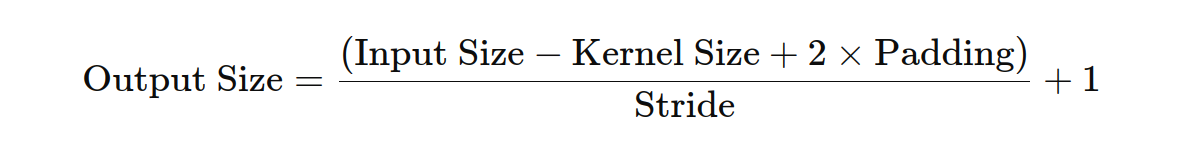


In [79]:
def calculate_output_size(input_size, kernel_size, stride=1, padding=0):
    output_size = ((input_size - kernel_size + 2 * padding) // stride) + 1
    return output_size

In [80]:
import torch
import torch.nn as nn
# from torchview import draw_graph

In [81]:
calculate_output_size(13,3,2,0)

6

In [82]:
class AlexNet(nn.Module):
    def __init__(self,num_class:int=1000,dropout:float=0.5):
        super().__init__()

        self.features = nn.Sequential(
            # input_shape = (batch,3,227,227)

            # first conv layer
            nn.Conv2d(in_channels=3,
                      out_channels=96,
                      kernel_size=11,
                      stride=4,
                      padding='valid'
                      ), # (batch, 96,55,55)


            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2), #(batch,96,27,27)



            # Second conv layer
            nn.Conv2d(in_channels=96,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding='same'
                      ), # (batch, 256,27,27)


            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2), #(batch,256,13,13)


            # Third Conv layer

            nn.Conv2d(in_channels=256,
                      out_channels=384,
                      kernel_size=3,
                      stride=1,
                      padding='same'
                      ), #(batch,384,13,13)
            nn.ReLU(inplace=True),

            # forth conv layer
            nn.Conv2d(in_channels=384,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding='same'
                      ), # (batch,256,13,13)
            nn.ReLU(inplace=True),

            # fifth conv layer
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding='same'
                      ), # (batch,256,13,13)
            nn.ReLU(inplace=True),

            nn.MaxPool2d(kernel_size=3,
                            stride=2) # (batch,256,6,6)
        )


        self.classifier = nn.Sequential(

            nn.Dropout(p=dropout),
            nn.Linear(in_features=256*6*6,out_features=4096),
            nn.ReLU(inplace=True),

            nn.Dropout(p=dropout),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=4096,out_features=num_class)
        )


    def forward(self,x:torch.Tensor) -> torch.Tensor:

        x = self.features(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x


In [83]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model = AlexNet(num_class=2).to(device)

In [84]:
# draw_graph(model,input_size=(1,3,227,227),expand_nested=True).visual_graph

# Training

In [85]:
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.transforms as T

In [86]:
transform_train = T.Compose(
    [T.Resize(256),
    T.RandomCrop(227),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])


transform_test = T.Compose(
    [T.Resize(256),
    T.CenterCrop(227),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    ]

)

In [87]:
train_dataset = datasets.ImageFolder(root="/content/cats_vs_dogs/train",
                                     transform=transform_train)


test_dataset = datasets.ImageFolder(root="/content/cats_vs_dogs/test",
                                     transform=transform_test)

In [88]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=64,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=64,
                         shuffle=False)

In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),
                      lr=0.01,
                      momentum=0.9,
                      weight_decay=5e-4
                      )

In [93]:
def train_model(model,train_loader,criterion,optimizer,num_epochs):
    model.train
    for epoch in range(num_epochs):
        running_loss = 0
        correct = 0
        total = 0

        for i, (inputs,labels) in enumerate(train_loader):

            inputs,labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()


            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step() # update weights

            # accuracy
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            running_loss += loss.item()

            # if i % 5 == 4:
            #     print(f"Epoch : {epoch} batch : {i} ")
        print(f"accuracy : {100*(correct / total)}% Loss : {running_loss}")




In [94]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs,labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _,predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test accuracy :  {correct / total}")

In [95]:
train_model(model,train_loader,criterion, optimizer, num_epochs=20)

accuracy : 53.25% Loss : 9.006823301315308
accuracy : 49.375% Loss : 9.012220919132233
accuracy : 53.87499999999999% Loss : 8.99513965845108
accuracy : 60.0% Loss : 8.979552805423737
accuracy : 59.875% Loss : 8.96055018901825
accuracy : 63.74999999999999% Loss : 8.888239622116089
accuracy : 65.875% Loss : 8.634291470050812
accuracy : 65.875% Loss : 8.250095903873444
accuracy : 69.5% Loss : 7.662282764911652
accuracy : 74.25% Loss : 6.821787178516388
accuracy : 80.625% Loss : 5.993377447128296
accuracy : 81.375% Loss : 5.3738535940647125
accuracy : 83.875% Loss : 4.684660106897354
accuracy : 82.875% Loss : 5.166582837700844
accuracy : 87.25% Loss : 3.7541383504867554
accuracy : 90.0% Loss : 3.129494793713093
accuracy : 89.875% Loss : 3.4658377841115
accuracy : 83.375% Loss : 5.346419170498848
accuracy : 87.75% Loss : 3.7385310381650925
accuracy : 90.625% Loss : 3.2531066834926605


In [96]:
test_model(model,test_loader)

Test accuracy :  0.93
